# RSI momentum trading strategy example

- This is a backtest example notebook
    - Check high trading fee options for ETH-MATIC-USDC

# Set up

Set up Trading Strategy data client.

In [1]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()


# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)
# etup_charting_and_output(width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Load data

We use Binance data so we get a longer period of data.

In [2]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId
from tradeexecutor.utils.binance import create_binance_universe

strategy_universe = create_binance_universe(
    ["BTCUSDT", "ETHUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.h8,
    stop_loss_time_bucket=TimeBucket.h1,
    start_at=datetime.datetime(2019, 1, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 3, 15),
    include_lending=False
)

# List of pair descriptions we used to look up pair metadata
our_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]


  0%|          | 0/2 [00:00<?, ?it/s]

# Show loaded trading universe

Display generic troubleshooting information about the loaded data.

In [3]:
from tradingstrategy.chain import ChainId

pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")

Loaded 11,402 candles.
Pair <Pair #1 BTC - USDT at exchange binance> first close price 3713.83 at 2019-01-01 00:00:00
Pair <Pair #2 ETH - USDT at exchange binance> first close price 133.56 at 2019-01-01 00:00:00


# Indicators

- Prepare indicators needed for the grid

In [4]:
import pandas_ta
import pandas as pd

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_price_series


def calculate_shifted_rsi(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.rsi(resampled_close, length=length)


def calculate_shifted_eth_btc(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """ETH/BTC price series."""
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    resampled_btc = resample_price_series(btc_price, upsample.to_pandas_timedelta(), shift=shift)
    resampled_eth = resample_price_series(eth_price, upsample.to_pandas_timedelta(), shift=shift)
    series = resampled_btc / resampled_eth  # Divide two series
    return series


def calculate_eth_btc(strategy_universe: TradingStrategyUniverse):
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])    
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    series = eth_price["close"] / btc_price["close"]  # Divide two series
    return series

def calculate_eth_btc_rsi(strategy_universe: TradingStrategyUniverse, length: int):
    weth_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WETH", "USDC"))
    wbtc_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WBTC", "USDC"))
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(wbtc_usdc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(weth_usdc.internal_id)
    eth_btc = eth_price["close"] / btc_price["close"]
    return pandas_ta.rsi(eth_btc, length=length)

def create_indicators(
    parameters: StrategyParameters,
    indicators: IndicatorSet,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    # Calculate RSI for all pairs
    indicators.add("rsi", calculate_shifted_rsi, {"length": parameters.rsi_bars, "upsample": parameters.upsample, "shift": parameters.shift})
    # Custom: ETC/BTC close price
    indicators.add("eth_btc", calculate_shifted_eth_btc, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)
    # Custom: ETC/BTC RSI
    # indicators.add("eth_btc_rsi", calculate_eth_btc_rsi, parameters={"length": parameters.eth_btc_rsi_bars}, source=IndicatorSource.strategy_universe)

# Trading algorithm

In [5]:
import pandas as pd

from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.strategy.weighting import weight_passthrouh
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.visualisation import PlotKind, PlotShape, PlotLabel
from tradeexecutor.state.trade import TradeExecution


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # Resolve our pair metadata for our two pair strategy
    parameters = input.parameters 
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    shift = parameters.shift
    clock_shift = pd.Timedelta(hours=1) * shift

    # Execute the daily trade cycle when the clock hour 0..24 is correct for our hourly shift
    assert parameters.upsample.to_timedelta() >= parameters.cycle_duration.to_timedelta(), "Upsample period must be longer than cycle period"    
    assert shift <= 0  # Shift -1 = do action 1 hour later

    # Override the trading fee to simulate worse fees and price impact
    if parameters.trading_fee_override is not None:
        input.pricing_model.set_trading_fee_override(parameters.trading_fee_override)    

    # Do the clock shift trick
    if parameters.cycle_duration.to_timedelta() != parameters.upsample.to_timedelta():
        if (input.cycle - 1 + shift) % int(parameters.upsample.to_hours()) != 0:
            return []

    alpha_model = AlphaModel(input.timestamp)
    btc_pair = position_manager.get_trading_pair(our_pairs[0])
    eth_pair = position_manager.get_trading_pair(our_pairs[1])
    position_manager.log("decide_trades() start")

    #
    # Indicators
    #
    # Calculate indicators for each pair.
    #

    # Per-trading pair calcualted data
    current_rsi_values = {}  # RSI yesterday
    previous_rsi_values = {}  # RSI day before yesterday
    current_price = {}  # Close price yesterday
    momentum = {btc_pair: 0, eth_pair: 0}
    eth_btc_rsi_yesterday = None

    for pair in [btc_pair, eth_pair]:        
        current_price[pair] = indicators.get_price(pair)

        current_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-1, pair=pair, clock_shift=clock_shift)
        previous_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-2, pair=pair, clock_shift=clock_shift)

        if shift and input.cycle > 100:
            indicators.get_indicator_value("rsi", index=-1 + shift, pair=pair, clock_shift=clock_shift)

    eth_btc_yesterday = indicators.get_indicator_value("eth_btc", clock_shift=clock_shift)
    eth_btc_rsi_yesterday = indicators.get_indicator_value("eth_btc_rsi", clock_shift=clock_shift)
    if eth_btc_rsi_yesterday is not None:
        eth_momentum = (eth_btc_rsi_yesterday / 100) + 0.5 
        btc_momentum = (1 - (eth_btc_rsi_yesterday / 100)) + 0.5
        momentum[eth_pair] = eth_momentum ** parameters.momentum_exponent
        momentum[btc_pair] = btc_momentum ** parameters.momentum_exponent

    #
    # Trading logic
    #

    for pair in [btc_pair, eth_pair]:

        # Each pair has its own bullish/bearish regime

        price = current_price[pair] 

        # 
        # Regime filter
        #
        # If no indicator data yet, or regime filter disabled,
        # be always bullish
        bullish = True  
        if parameters.regime_filter_ma_days:  # Regime filter is not disabled
            regime_filter_pair = btc_pair if parameters.regime_filter_only_btc else pair
            regime_filter_price = current_price[regime_filter_pair]
            sma = indicators.get_indicator_value("sma", index=-1, pair=regime_filter_pair, clock_shift=clock_shift)
            if sma:
                # We are bearish if close price is beloe SMA
                bullish = regime_filter_price > sma
        
        if bullish:
            rsi_entry = parameters.bullish_rsi_entry
            rsi_exit = parameters.bullish_rsi_exit
        else:
            rsi_entry = parameters.bearish_rsi_entry
            rsi_exit = parameters.bearish_rsi_exit            

        existing_position = position_manager.get_current_position_for_pair(pair)
        pair_open = existing_position is not None
        pair_momentum = momentum.get(pair, 0)
        signal_strength = max(pair_momentum, 0.1)  # Singal strength must be positive, as we do long-only
        if pd.isna(signal_strength):
            signal_strength = 0
        alpha_model.set_signal(pair, 0)

        if pair_open:
            # We have existing open position for this pair,
            # keep it open by default unless we get a trigger condition below
            position_manager.log(f"Pair {pair} already open")
            alpha_model.set_signal(pair, signal_strength, stop_loss=parameters.stop_loss)

        if current_rsi_values[pair] and previous_rsi_values[pair]:

            # Check for RSI crossing our threshold values in this cycle, compared to the previous cycle
            if rsi_entry:
                rsi_cross_above = current_rsi_values[pair] >= rsi_entry and previous_rsi_values[pair] < rsi_entry
            else:
                # bearish_rsi_entry = None -> don't trade in bear market
                rsi_cross_above = False

            rsi_cross_below = current_rsi_values[pair] < rsi_exit and previous_rsi_values[pair] > rsi_exit

            if not pair_open:
                # Check for opening a position if no position is open
                if rsi_cross_above:
                    position_manager.log(f"Pair {pair} crossed above")
                    alpha_model.set_signal(pair, signal_strength, stop_loss=parameters.stop_loss)
            else:
                # We have open position, check for the close condition
                if rsi_cross_below:
                    position_manager.log(f"Pair {pair} crossed below")
                    alpha_model.set_signal(pair, 0)

    # Enable trailing stop loss if we have reached the activation level
    if parameters.trailing_stop_loss_activation_level is not None and parameters.trailing_stop_loss is not None:
       for p in state.portfolio.open_positions.values():
           if p.trailing_stop_loss_pct is None:
               if current_price[p.pair] >= p.get_opening_price() * parameters.trailing_stop_loss_activation_level:
                   p.trailing_stop_loss_pct = parameters.trailing_stop_loss

    # Use alpha model and construct a portfolio of two assets
    alpha_model.select_top_signals(2)
    alpha_model.assign_weights(weight_passthrouh)
    alpha_model.normalise_weights()
    alpha_model.update_old_weights(state.portfolio)
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=parameters.rebalance_threshold * portfolio.get_total_equity(),
    )

    #
    # Visualisations
    #

    if input.is_visualisation_enabled():

        visualisation = state.visualisation  # Helper class to visualise strategy output

        # BTC RSI daily
        if current_rsi_values[btc_pair]:
            visualisation.plot_indicator(
                timestamp,
                f"RSI BTC",
                PlotKind.technical_indicator_detached,
                current_rsi_values[btc_pair],
                colour="orange",
            )


            # Low (vertical line)
            visualisation.plot_indicator(
                timestamp,
                f"RSI low trigger",
                PlotKind.technical_indicator_overlay_on_detached,
                parameters.rsi_low,
                detached_overlay_name=f"RSI BTC",
                plot_shape=PlotShape.horizontal_vertical,
                colour="red",
                label=PlotLabel.hidden,
            )

            # High (vertical line)
            visualisation.plot_indicator(
                timestamp,
                f"RSI high trigger",
                PlotKind.technical_indicator_overlay_on_detached,
                parameters.rsi_high,
                detached_overlay_name=f"RSI BTC",
                plot_shape=PlotShape.horizontal_vertical,
                colour="red",
                label=PlotLabel.hidden,
            )

        # ETH RSI daily
        if current_rsi_values[eth_pair]:
            visualisation.plot_indicator(
                timestamp,
                f"RSI ETH",
                PlotKind.technical_indicator_overlay_on_detached,
                current_rsi_values[eth_pair],
                colour="blue",
                label=PlotLabel.hidden,
                detached_overlay_name=f"RSI BTC",
            )

        if eth_btc_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC",
                PlotKind.technical_indicator_detached,
                eth_btc_yesterday,
                colour="grey",
            )

        if eth_btc_rsi_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC RSI",
                PlotKind.technical_indicator_detached,
                eth_btc_rsi_yesterday,
                colour="grey",
            )

        state.visualisation.add_calculations(timestamp, alpha_model.to_dict())  # Record alpha model thinking

    position_manager.log(
        f"BTC RSI: {current_rsi_values[btc_pair]}, BTC RSI yesterday: {previous_rsi_values[btc_pair]}",
    )

    return trades

# Strategy indicators

- Set up indicators used to decide trades
- Indicator data will be precalculated and cached between strategy runs 
- The actual calculation is run (if needed) later on `run_backtest_inline()` call

In [6]:
import pandas_ta

from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def calculate_shifted_btc_price(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """"BTC price (shifted)

    "For diagnostics.
    """
    btc = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    resampled_btc = resample_price_series(btc_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    return resampled_btc


def calculate_shifted_rsi(pair_close_price_series: pd.Series, length: int, upsample: TimeBucket, shift: int):
    resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
    return pandas_ta.rsi(resampled_close, length=length)


def calculate_shifted_sma(pair_close_price_series: pd.Series, days: int | None, upsample: TimeBucket, shift: int):
    if days:
        # Calculate trading pair simple moving average for X days
        resampled_close = resample_price_series(pair_close_price_series, upsample.to_pandas_timedelta(), shift=shift)
        return pandas_ta.sma(resampled_close, length=days * (TimeBucket.d1.to_hours() / upsample.to_hours()))
    else:
        # Regime filter disabled in the parameters
        return pd.Series(dtype="float64")


def calculate_shifted_eth_btc(strategy_universe: TradingStrategyUniverse, upsample: TimeBucket, shift: int):
    """ETH/BTC price series."""
    btc = strategy_universe.get_pair_by_human_description(our_pairs[0])
    eth = strategy_universe.get_pair_by_human_description(our_pairs[1])
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    resampled_btc = resample_price_series(btc_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    resampled_eth = resample_price_series(eth_price["close"], upsample.to_pandas_timedelta(), shift=shift)
    series = resampled_eth / resampled_btc
    return series


def calculate_shifted_eth_btc_rsi(strategy_universe: TradingStrategyUniverse, length: int, upsample: TimeBucket, shift: int):
     """ETH/BTC RSI series."""
     etc_btc = calculate_shifted_eth_btc(strategy_universe, upsample, shift)
     return pandas_ta.rsi(etc_btc, length=length)


def create_indicators(
    parameters: StrategyParameters,
    indicators: IndicatorSet,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators.add("rsi", calculate_shifted_rsi, {"length": parameters.rsi_bars, "upsample": parameters.upsample, "shift": parameters.shift})
    indicators.add("sma", calculate_shifted_sma, {"days": parameters.regime_filter_ma_days, "upsample": parameters.upsample, "shift": parameters.shift})
    indicators.add("eth_btc", calculate_shifted_eth_btc, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)
    indicators.add("eth_btc_rsi", calculate_shifted_eth_btc_rsi, {"upsample": parameters.upsample, "shift": parameters.shift, "length": parameters.eth_btc_rsi_bars}, source=IndicatorSource.strategy_universe)
    indicators.add("resampled_btc", calculate_shifted_btc_price, {"upsample": parameters.upsample, "shift": parameters.shift}, source=IndicatorSource.strategy_universe)


# Parameters

- Set up strategy parameters for this backtest run

In [7]:
class HighFeeStopLossStrategyParameters:
    cycle_duration = CycleDuration.cycle_8h
    rsi_bars = [8, 12, 21, 30]
    eth_btc_rsi_bars = 5
    
    #bullish_rsi_entry = [50, 55, 60, 65, 70, 75, 80]
    #$bullish_rsi_exit = [50, 55, 60, 65, 70, 75, 80]

    #bearish_rsi_entry = [50, 55, 60, 65, 67, 70, 75, 80, None]
    #bearish_rsi_exit = [50, 54, 60, 65, 67, 70, 75, 80]

    #regime_filter_ma_length = [50, 100, 150, 200, None] 
    #regime_filter_only_btc = [1, 0]

    bullish_rsi_entry = [50, 60]
    bullish_rsi_exit = [60]
    bearish_rsi_entry = [50, 60, None]
    bearish_rsi_exit = [60]
    regime_filter_ma_days = [50, None] 
    regime_filter_only_btc = 1

    allocation = 0.98 
    rebalance_threshold = 0.275
    initial_cash = 10_000 
    #trailing_stop_loss = 0.975
    #trailing_stop_loss_activation_level = 1.06
    #stop_loss = 0.85
    trailing_stop_loss = None
    trailing_stop_loss_activation_level = None
    stop_loss = None
    shift = 0    
    upsample = TimeBucket.h8
    momentum_exponent = 2.5
    trading_fee_override = 0.0030
    

# Grid search

Run the grid search.

In [8]:
from tradeexecutor.backtest.grid_search import GridCombination, get_grid_search_result_path, perform_grid_search, prepare_grid_combinations

# This is the path where we keep the result files around
storage_folder = get_grid_search_result_path("v43")

# Popular grid search combinations and indicators for them
combinations = prepare_grid_combinations(
    HighFeeStopLossStrategyParameters, 
    storage_folder,
    create_indicators=create_indicators,
    strategy_universe=strategy_universe,
)

indicators = GridCombination.get_all_indicators(combinations)

print(f"We prepared {len(combinations)} grid search combinations with total {len(indicators)} indicators which need to be calculated, stored in {storage_folder.resolve()}")

grid_search_results = perform_grid_search(
    decide_trades,
    strategy_universe,
    combinations,
    trading_strategy_engine_version="0.5",
    multiprocess=True,
)

We prepared 48 grid search combinations with total 15 indicators which need to be calculated, stored in /Users/moo/.cache/trading-strategy/grid-search/v43
Using indicator cache /Users/moo/.cache/indicators/centralised-exchange_8h_BTC-USDT-ETH-USDT_2019-01-01-2024-03-15
No cached grid search results found from previous runs


Searching:   0%|          | 0/48 [00:00<?, ?it/s]

# Grid search result comparison

In [9]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.analysis.grid_search import analyse_grid_search_result
from tradeexecutor.analysis.grid_search import visualise_table

# Print extension of our backtest
cached_results = [r for r in grid_search_results if r.cached]
print(f"Grid search results available: {len(grid_search_results)}, of which we got cached {len(cached_results)} in {storage_folder}")

#table = analyse_grid_search_result(grid_search_results)
#table = table.reset_index()
#visualise_table(table)

Grid search results available: 48, of which we got cached 0 in /Users/moo/.cache/trading-strategy/grid-search/v43


## Best CAGR and Sharpe - overall

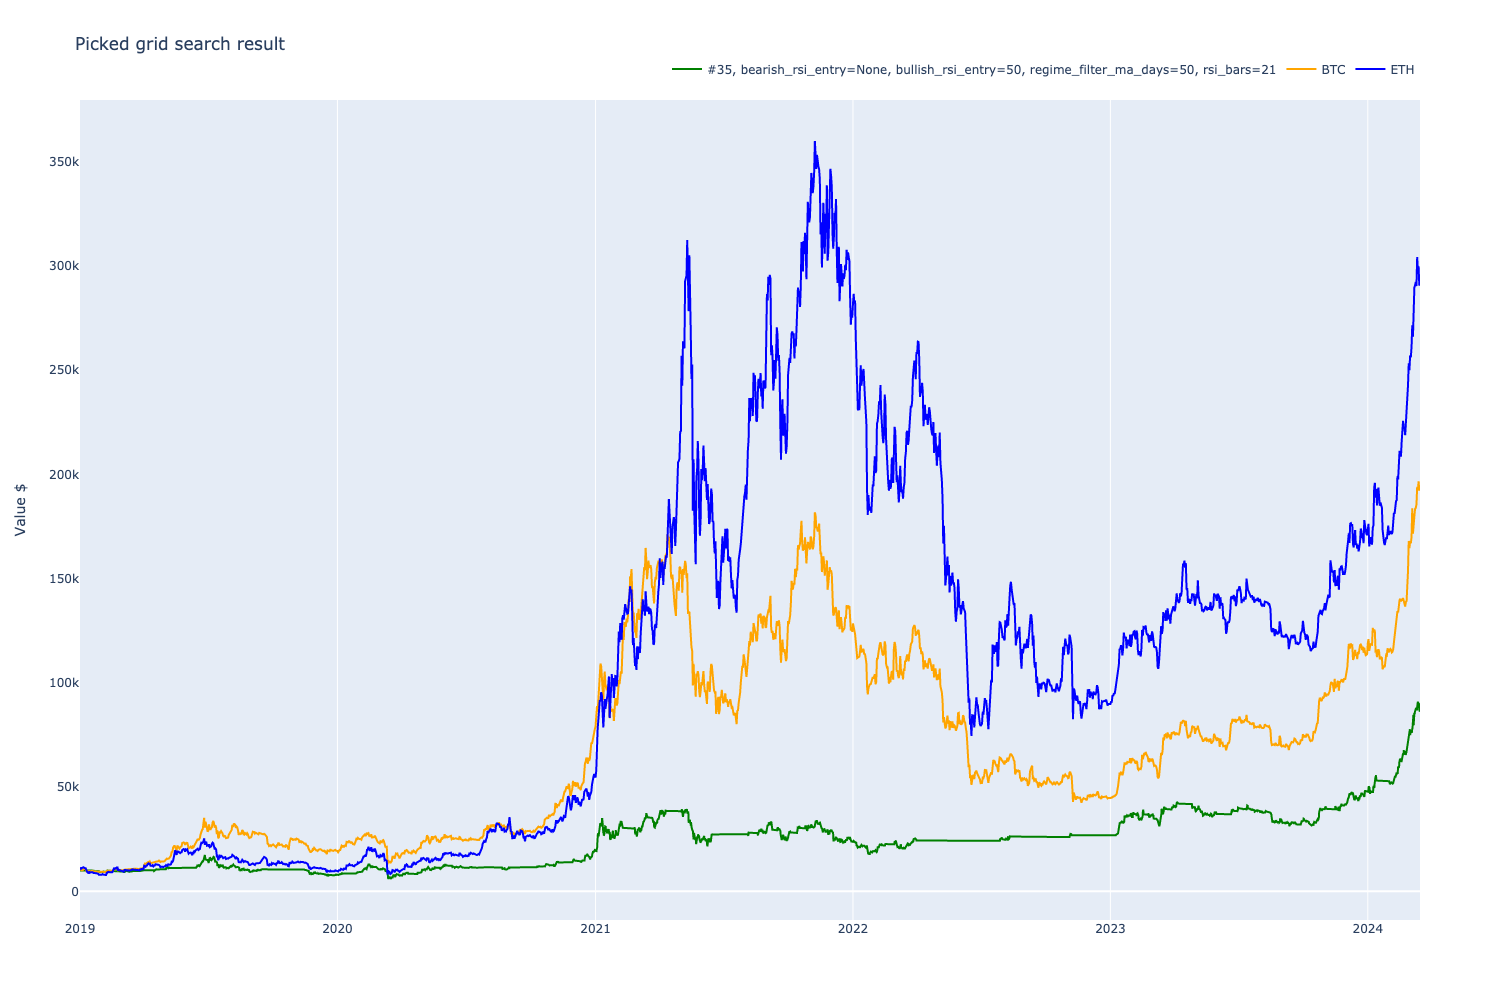

In [10]:
from tradeexecutor.analysis.grid_search import find_best_grid_search_results, render_grid_search_result_table
from tradeexecutor.visual.grid_search import visualise_single_grid_search_result_benchmark

best_results = find_best_grid_search_results(grid_search_results)
render_grid_search_result_table(best_results.cagr)

fig = visualise_single_grid_search_result_benchmark(best_results.cagr[0], strategy_universe)
fig.show()

In [11]:
render_grid_search_result_table(best_results.sharpe)

We have 0 filtered results


/var/folders/12/pbc59svn70q_9dfz1kjl3zww0000gn/T/ipykernel_91001/2709437681.py:16: DeprecationWarning:

use tradeexecutor.visual.grid_search.visualise_grid_search_equity_curves instead



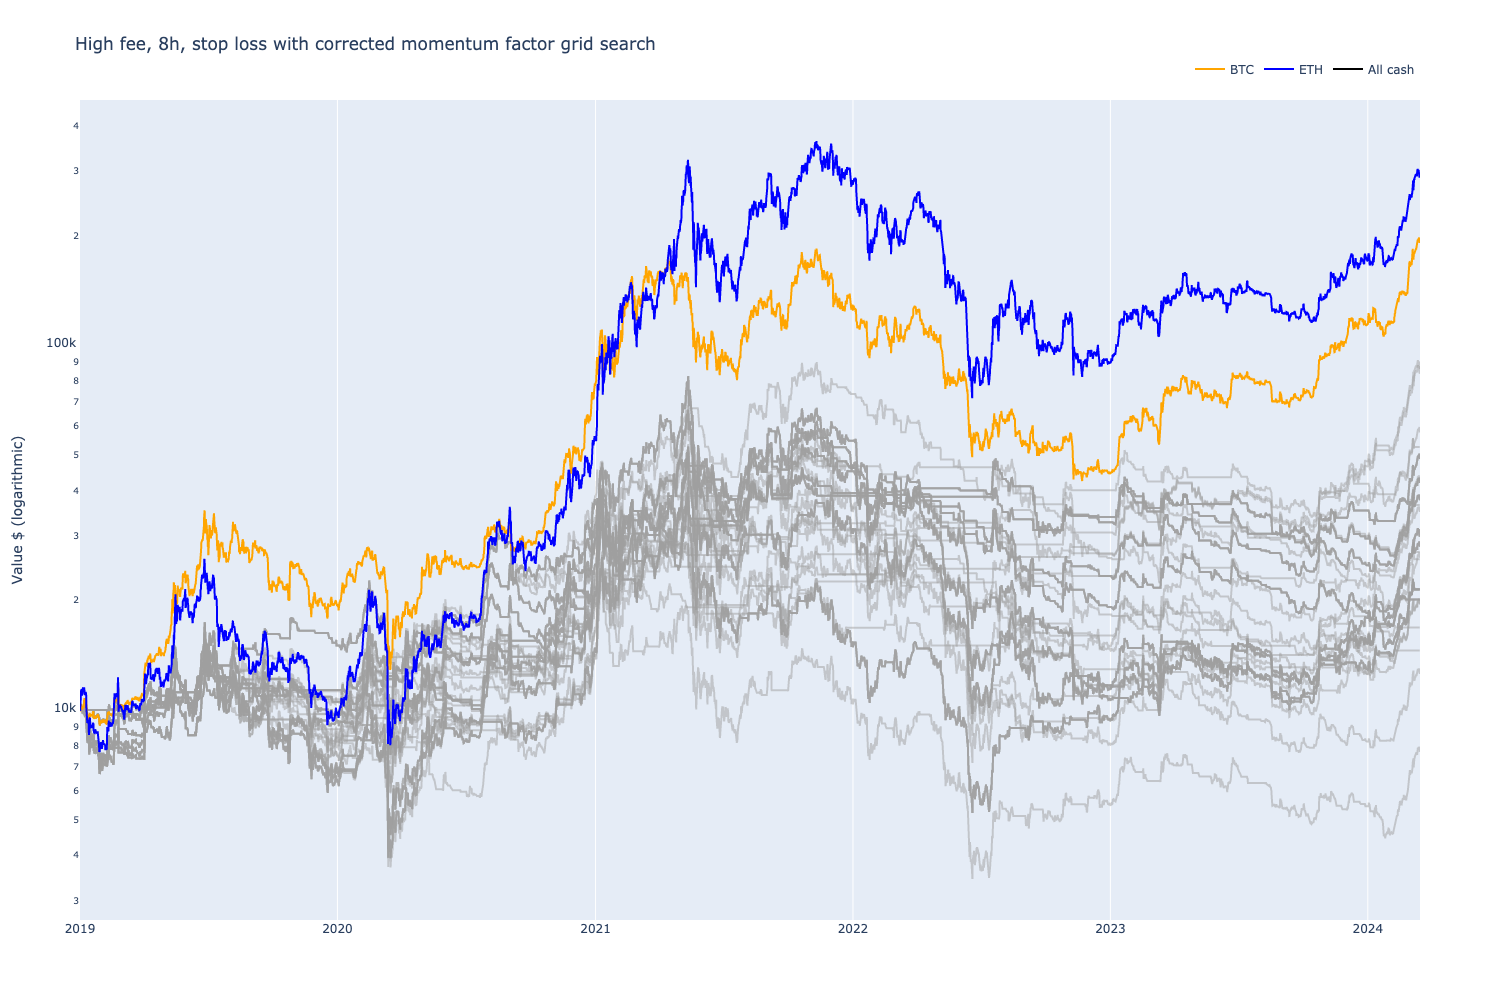

In [12]:
from tradeexecutor.analysis.grid_search import visualise_grid_search_equity_curves
from tradeexecutor.visual.benchmark import create_benchmark_equity_curves

benchmark_indexes = create_benchmark_equity_curves(
    strategy_universe,
    {"BTC": our_pairs[0], "ETH": our_pairs[1]},
    initial_cash=HighFeeStopLossStrategyParameters.initial_cash,
)

# Limit number of curves to draw,
# otherwise Plotly will crash
#print(grid_search_results[0].metrics["Strategy"])
filtered_results = [r for r in grid_search_results if (r.metrics["Strategy"]["Max Drawdown"] > -0.25 and r.metrics["Strategy"]["CAGR﹪"] > 0.70)]
print(f"We have {len(filtered_results)} filtered results")

fig = visualise_grid_search_equity_curves(
    grid_search_results,
    name="High fee, 8h, stop loss with corrected momentum factor grid search",
    benchmark_indexes=benchmark_indexes,
    log_y=True,
)
fig.show()